## 환경 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import sys

#경고창이 뜨지 않도록 해주는 것
import warnings
warnings.filterwarnings('ignore')

# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것
%matplotlib inline 

**주피터 노트북에서 시각화할때, matplotlib가 한글 폰트 지원하지 않아, 깨짐 처리해줘야 함**

In [3]:
import platform                

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': #맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':#윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

# 데이터 불러오기 
- 데이터가 크다보니 속도가 오래걸리기도 합니다..!
- 아직 이런 문제를 해결하는 방법에 대한 에듀세션을 배우지 않았으니,
- 각자의 컴퓨터가 감당할 수 있는 만큼, 그리고 지금껏 에듀세션에서 배운 내용으로 최대한 성능개선을 해보시되, 
- 절대적인 accuracy 수치에 대해 부담은 갖지 않으셔도 됩니다! 몇 %라도 개선되었다면 좋습니다 ㅎㅎ

In [6]:
# 데이터 불러오기 
df = pd.read_csv('NYC_taxi.csv') # 파일경로 알맞게 지정해주세요 


# 여기 아래 부분 꼭 실행시켜주세요! 
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])
df['zip_code'] = df['zip_code'].astype(str) 




### 모델링할 때 램이 자꾸 터진다면... row 수, 즉 날짜를 줄이거나 특정 지역의 정보만 선택해서 넣으세요! 
## 날짜 줄이기 
#df = df.iloc[0:7000, :] #7000개만 남기기 
##지역 수 줄이기 

zip_code_list = ['10001', '10002', '10115', '10026', '10027', '10029', '10030', '11797', '11801'] # 더 많은 지역을 포함해도 됩니다! 컴퓨터가 버틸 수 있을 만큼만..! 
df = df[df.zip_code.isin(zip_code_list)]
df = df.reset_index()
df = df.drop(['index'], axis = 1)

In [7]:
df

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,10001,2015-01-01 00:00:00,1,1,3,0,0,1221
1,10030,2015-01-01 00:00:00,1,1,3,0,0,36
2,10029,2015-01-01 00:00:00,1,1,3,0,0,204
3,10026,2015-01-01 00:00:00,1,1,3,0,0,120
4,10027,2015-01-01 00:00:00,1,1,3,0,0,206
...,...,...,...,...,...,...,...,...
4642,10001,2015-01-31 23:00:00,1,31,5,23,1,1300
4643,10029,2015-01-31 23:00:00,1,31,5,23,1,166
4644,10026,2015-01-31 23:00:00,1,31,5,23,1,83
4645,10002,2015-01-31 23:00:00,1,31,5,23,1,1168


# 데이터 전처리 
### (전처리 파일을 복붙해오시고, 모델별로 다르게 적용하실때마다 복붙해서 사용하시면 되겠습니다) 

### 모델링을 위한 기본 전처리
  - `기본 정보 확인 (결측치 및 이상치 처리)`
      - df.info()
      - df.describe()
      - 간단한 시각화 
  - `시간 관련 전처리 (새로운 열 생성)` 
      - DATETIME에서 MONTH, HOUR, WEEKDAY 등 추출
  - `Categorical 데이터 전처리`
      - One Hot Encoding
      - Label Encoding
  - `Train / Test Split`
    - NY taxi data에서 주의점 

### 기본 정보 확인 (결측치 및 이상치 처리) 
  - df.info()
  - df.describe()
  - 간단한 시각화 



---


EDA 과정에서 기본적으로 다 확인하셨죠? ㅎㅎ 
EDA 결과 중 모델링에 적용하기로한 부분이 있다면 반영해주세요~!

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4647 entries, 0 to 4646
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   zip_code     4647 non-null   object        
 1   pickup_hour  4647 non-null   datetime64[ns]
 2   month        4647 non-null   int64         
 3   day          4647 non-null   int64         
 4   weekday      4647 non-null   int64         
 5   hour         4647 non-null   int64         
 6   is_weekend   4647 non-null   int64         
 7   cnt          4647 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 290.6+ KB


### `Categorical 데이터 전처리`

기본적으로 사이킷런의 머신러닝 알고리즘은 문자열 값을 입력 값으로 허락하지 않습니다. 또한, 먆은 알고리즘이 범주형 데이터로 직접 작동할 수 없습니다. 그렇기 때문에 모든 문자열 값들을 숫자 형으로 인코딩하는 전처리 작업 후에 머신러닝 모델에 학습을 시켜야하는데요. 이렇게 인코딩 하는 방식에는 크게 레이블 인코딩(Lable encoding)과 원-핫 인코딩(One Hot Encoding)이 있습니다. 

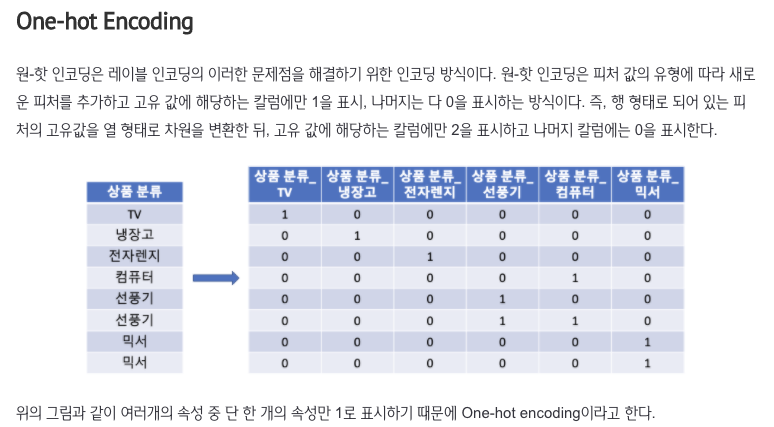

In [9]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [10]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['zip_code']])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [11]:
ohe_output = enc.transform(df[['zip_code']]).toarray()
oh_feature_df = pd.concat([df, pd.DataFrame(ohe_output, columns='zip_code_'+ enc.categories_[0])], axis=1)
oh_feature_df.head(3)

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,zip_code_10026,zip_code_10027,zip_code_10029,zip_code_10030,zip_code_10115,zip_code_11797,zip_code_11801
0,10001,2015-01-01,1,1,3,0,0,1221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10030,2015-01-01,1,1,3,0,0,36,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,10029,2015-01-01,1,1,3,0,0,204,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Train and Test Split
- 시계열 데이터는 Random Sampling을 하면 안됨
- Train엔 과거 데이터, Test엔 (과거 대비) 미래 데이터가 있어야 함
    - 만약 Train에 미래 데이터가 있다면? 미래를 보고 과거를 예측한 꼴
    - 실제로 사용할 땐 과거 데이터 기반으로 미래 데이터를 예측

In [12]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

- 위 방법은 명시적으로 date를 지정하는 방법이 마음에 들지 않을수도 있음
    - 이럴 경우 Dataframe의 시간 데이터를 마지막 1주치만 Test로 지정할 수 있음

In [13]:
def split_train_and_test_period(df, period):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    period : train/test 기준 일
    """
    criteria = (max(df['pickup_hour']) - pd.Timedelta(days=period)).date()
    train_df = df[df['pickup_hour'] < criteria]
    test_df = df[df['pickup_hour'] >= criteria]
    return train_df, test_df

### Train / Test 나누기

In [14]:
train_df, test_df = split_train_and_test(oh_feature_df, '2015-01-24') # 원핫인코

In [15]:
train_df

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,zip_code_10026,zip_code_10027,zip_code_10029,zip_code_10030,zip_code_10115,zip_code_11797,zip_code_11801
0,10001,2015-01-01 00:00:00,1,1,3,0,0,1221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10030,2015-01-01 00:00:00,1,1,3,0,0,36,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,10029,2015-01-01 00:00:00,1,1,3,0,0,204,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,10026,2015-01-01 00:00:00,1,1,3,0,0,120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10027,2015-01-01 00:00:00,1,1,3,0,0,206,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,10027,2015-01-23 23:00:00,1,23,4,23,0,80,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3451,10029,2015-01-23 23:00:00,1,23,4,23,0,125,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3452,10002,2015-01-23 23:00:00,1,23,4,23,0,1134,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3453,10001,2015-01-23 23:00:00,1,23,4,23,0,1274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
test_df

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,zip_code_10026,zip_code_10027,zip_code_10029,zip_code_10030,zip_code_10115,zip_code_11797,zip_code_11801
3455,10029,2015-01-24 00:00:00,1,24,5,0,1,119,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3456,10026,2015-01-24 00:00:00,1,24,5,0,1,55,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3457,10030,2015-01-24 00:00:00,1,24,5,0,1,8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3458,10001,2015-01-24 00:00:00,1,24,5,0,1,1167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3459,10027,2015-01-24 00:00:00,1,24,5,0,1,68,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4642,10001,2015-01-31 23:00:00,1,31,5,23,1,1300,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4643,10029,2015-01-31 23:00:00,1,31,5,23,1,166,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4644,10026,2015-01-31 23:00:00,1,31,5,23,1,83,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4645,10002,2015-01-31 23:00:00,1,31,5,23,1,1168,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']
# del train_df['zip_code_le']
# del test_df['zip_code_le']

In [18]:
train_df

,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,zip_code_10026,zip_code_10027,zip_code_10029,zip_code_10030,zip_code_10115,zip_code_11797,zip_code_11801
0,1,1,3,0,0,1221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,3,0,0,36,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1,3,0,0,204,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,3,0,0,120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,3,0,0,206,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,1,23,4,23,0,80,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3451,1,23,4,23,0,125,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3452,1,23,4,23,0,1134,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3453,1,23,4,23,0,1274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
y_train = train_df.pop('cnt')
x_train = train_df.copy()

In [20]:
y_test = test_df.pop('cnt')
x_test = test_df.copy()

In [21]:
x_train

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10026,zip_code_10027,zip_code_10029,zip_code_10030,zip_code_10115,zip_code_11797,zip_code_11801
0,1,1,3,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1,3,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,3,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,3,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,1,23,4,23,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3451,1,23,4,23,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3452,1,23,4,23,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3453,1,23,4,23,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
y_train

0       1221
1         36
2        204
3        120
4        206
        ... 
3450      80
3451     125
3452    1134
3453    1274
3454      45
Name: cnt, Length: 3455, dtype: int64

In [23]:
x_test

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10026,zip_code_10027,zip_code_10029,zip_code_10030,zip_code_10115,zip_code_11797,zip_code_11801
3455,1,24,5,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3456,1,24,5,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3457,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3458,1,24,5,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3459,1,24,5,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4642,1,31,5,23,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4643,1,31,5,23,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4644,1,31,5,23,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4645,1,31,5,23,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y_test

3455     119
3456      55
3457       8
3458    1167
3459      68
        ... 
4642    1300
4643     166
4644      83
4645    1168
4646      99
Name: cnt, Length: 1192, dtype: int64

# 모델링

 


### XGBoost Regressor

In [25]:
pip install xgboost

In [26]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score


In [27]:
xgbr = xgb.XGBRegressor(n_estimators = 200, learning_rate=0.1, max_depth = 3, subsample=0.9)
xgbr.fit(x_train, y_train)

[10:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)

#### model 평가

In [28]:
y_pred = xgbr.predict(x_test)
y_true = y_test

In [29]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)


print(f'mae = {mae:.2f}')
print(f'mse = {mse:.2f}')

mae = 79.23
mse = 29493.51


outlier와 bias를 보다 잘 처리해주고, MAPE가 가지고 있던 한계를 일부 보완한 SMAPE

- SMAPE 또한 0에 가까울수록 정확도가 높은 것

In [30]:
def sMAPE(y_true, y_pred):

    return np.mean(np.abs((y_true - y_pred))) / np.mean(y_true+y_pred) * 100

In [31]:
print(f'SMAPE = {sMAPE(y_true, y_pred):.2f}%')

SMAPE = 17.19%


K-fold validation으로 정확도 산출

In [32]:
x_data = pd.concat([x_train, x_test])

In [33]:
y_data = pd.concat([y_train, y_test])

In [34]:
scores = cross_val_score(xgbr, x_data, y_data, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

[10:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean cross-validation score: 0.84


#### 그래프를 통해 정확도 시각화

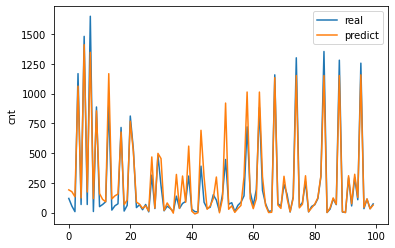

In [35]:
x_ax = range(100)
sns.lineplot(x = x_ax, y = y_test[:100], label='real')
sns.lineplot(x = x_ax, y = y_pred[:100], label='predict')
plt.legend()
plt.show()

#### Hyperparameter tuning

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
xgb1 = xgb.XGBRegressor()
parameters = { 
              'learning_rate': [0.03, 0.05, 0.1], #so called `eta` value
              'max_depth': [3, 5, 7],
              'n_estimators': [50,100, 500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.9s


[10:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9125154771588756
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50}


[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed:   19.1s finished


In [38]:
xgbr = xgb.XGBRegressor(n_estimators = 50, learning_rate=0.05, max_depth = 5)
xgbr.fit(x_train, y_train)

[10:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
y_pred = xgbr.predict(x_test)
y_true = y_test

SMPE가 다소 감소 

In [40]:
print(f'SMAPE = {sMAPE(y_true, y_pred):.2f}%')

SMAPE = 15.41%


K-fold validation으로 정확도 산출

In [41]:
scores = cross_val_score(xgbr, x_data, y_data, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

[10:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean cross-validation score: 0.88


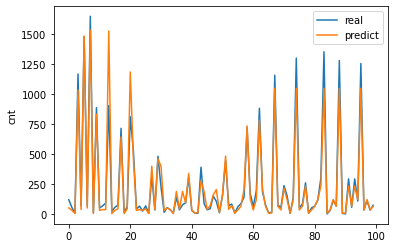

In [42]:
x_ax = range(100)
sns.lineplot(x = x_ax, y = y_test[:100], label='real')
sns.lineplot(x = x_ax, y = y_pred[:100], label='predict')
plt.legend()
plt.show()